**1️⃣ SPARK SESSION CONFIGURATION (RESOURCE OPTIMIZED)**

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Coventry_UK_Collision_Distributed_Project") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

**2️⃣ DATA INGESTION + VALIDATION**

In [2]:
from pyspark.sql.functions import expr

raw_df = spark.read \
    .option("header", "true") \
    .option("mode", "PERMISSIVE") \
    .csv("/content/dft-road-casualty-statistics-collision-1979-latest-published-year.csv")

# Safe casting using try_cast
df = raw_df.select(
    expr("try_cast(collision_year as int) as collision_year"),
    expr("try_cast(collision_severity as double) as collision_severity"),
    expr("try_cast(number_of_vehicles as int) as number_of_vehicles"),
    expr("try_cast(number_of_casualties as int) as number_of_casualties"),
    expr("try_cast(speed_limit as int) as speed_limit"),
    expr("try_cast(weather_conditions as int) as weather_conditions"),
    expr("try_cast(road_surface_conditions as int) as road_surface_conditions"),
    expr("try_cast(light_conditions as int) as light_conditions"),
    "time"
)

df = df.dropna(subset=["collision_severity"])

**3️⃣ PARTITIONING + PARQUET STORAGE**

In [3]:
df = df.repartition("collision_year")

df.write \
  .partitionBy("collision_year") \
  .mode("overwrite") \
  .parquet("collision_parquet")

df = spark.read.parquet("collision_parquet")

**4️⃣ CUSTOM TRANSFORMER (DOMAIN FEATURE ENGINEERING)**

In [4]:
from pyspark.ml import Transformer
from pyspark.sql.functions import hour, to_timestamp

class TimeFeatureTransformer(Transformer):
    def _transform(self, dataset):
        dataset = dataset.withColumn(
            "parsed_time",
            to_timestamp("time", "HH:mm")
        )
        return dataset.withColumn(
            "hour_of_day",
            hour("parsed_time")
        )

time_transformer = TimeFeatureTransformer()
df = time_transformer.transform(df)
df = df.fillna(0)

**5️⃣ CACHING STRATEGY**

In [5]:
df.persist()
print("Total Rows:", df.count())

Total Rows: 706953


**6️⃣ VECTOR ASSEMBLY**

In [6]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "collision_year",
    "number_of_vehicles",
    "number_of_casualties",
    "speed_limit",
    "weather_conditions",
    "road_surface_conditions",
    "light_conditions",
    "hour_of_day"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

data = assembler.transform(df) \
    .select("features", df.collision_severity.alias("label"))

**7️⃣ TRAIN TEST SPLIT**

In [7]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

**8️⃣ MLlib MODELS (4 Algorithms)**

In [8]:
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)

from pyspark.ml.evaluation import RegressionEvaluator
import time

evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# ---------------- Linear Regression ----------------
start = time.time()
lr = LinearRegression()
lr_model = lr.fit(train)
lr_time = time.time() - start
lr_rmse = evaluator.evaluate(lr_model.transform(test))

# ---------------- Decision Tree ----------------
start = time.time()
dt = DecisionTreeRegressor()
dt_model = dt.fit(train)
dt_time = time.time() - start
dt_rmse = evaluator.evaluate(dt_model.transform(test))

# ---------------- Random Forest ----------------
start = time.time()
rf = RandomForestRegressor(numTrees=50, maxDepth=10)
rf_model = rf.fit(train)
rf_time = time.time() - start
rf_rmse = evaluator.evaluate(rf_model.transform(test))

# ---------------- GBT ----------------
start = time.time()
gbt = GBTRegressor(maxIter=20)
gbt_model = gbt.fit(train)
gbt_time = time.time() - start
gbt_rmse = evaluator.evaluate(gbt_model.transform(test))

print("LR RMSE:", lr_rmse, "Time:", lr_time)
print("DT RMSE:", dt_rmse, "Time:", dt_time)
print("RF RMSE:", rf_rmse, "Time:", rf_time)
print("GBT RMSE:", gbt_rmse, "Time:", gbt_time)

LR RMSE: 0.4387578307264876 Time: 15.10507869720459
DT RMSE: 0.4355058378426218 Time: 17.448976516723633
RF RMSE: 0.4323217879164022 Time: 98.78532242774963
GBT RMSE: 0.43285855980810045 Time: 63.87216901779175


**9️⃣ DISTRIBUTED CROSS VALIDATION**

In [9]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4
)

cv_model = crossval.fit(train)
best_rmse = evaluator.evaluate(cv_model.transform(test))

print("Best Tuned RF RMSE:", best_rmse)

Best Tuned RF RMSE: 0.4323217879164022


**🔟 MODEL SERIALIZATION**

In [14]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

sample_pd = data.limit(50000).toPandas()

X = pd.DataFrame(sample_pd["features"].tolist())
y = sample_pd["label"]

import time
start = time.time()
rf_sklearn = RandomForestRegressor()
rf_sklearn.fit(X, y)
sk_time = time.time() - start

print("Sklearn RF Training Time:", sk_time)

Sklearn RF Training Time: 6.114532470703125


In [77]:
print("Total Rows:", df.count())
print("Total Columns:", len(df.columns))

df.printSchema()

df.show(5)

Total Rows: 248497
Total Columns: 12
root
 |-- collision_index: string (nullable = true)
 |-- collision_year: integer (nullable = true)
 |-- collision_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- speed_limit: integer (nullable = true)
 |-- weather_conditions: integer (nullable = true)
 |-- road_surface_conditions: integer (nullable = true)
 |-- light_conditions: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- parsed_time: timestamp (nullable = true)
 |-- hour_of_day: integer (nullable = true)

+---------------+--------------+------------------+------------------+--------------------+-----------+------------------+-----------------------+----------------+-----+-------------------+-----------+
|collision_index|collision_year|collision_severity|number_of_vehicles|number_of_casualties|speed_limit|weather_conditions|road_surface_conditions|light_conditions| time|        par

In [78]:
from pyspark.sql.functions import col, sum

missing = df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

missing.show()

+---------------+--------------+------------------+------------------+--------------------+-----------+------------------+-----------------------+----------------+----+-----------+-----------+
|collision_index|collision_year|collision_severity|number_of_vehicles|number_of_casualties|speed_limit|weather_conditions|road_surface_conditions|light_conditions|time|parsed_time|hour_of_day|
+---------------+--------------+------------------+------------------+--------------------+-----------+------------------+-----------------------+----------------+----+-----------+-----------+
|              0|             0|                 0|                 0|                   0|          0|                 0|                      0|               0|   0|          0|          0|
+---------------+--------------+------------------+------------------+--------------------+-----------+------------------+-----------------------+----------------+----+-----------+-----------+



In [79]:
df.groupBy("collision_severity") \
  .count() \
  .orderBy("collision_severity") \
  .show()

+------------------+------+
|collision_severity| count|
+------------------+------+
|                 1|  3963|
|                 2| 45206|
|                 3|199328|
+------------------+------+



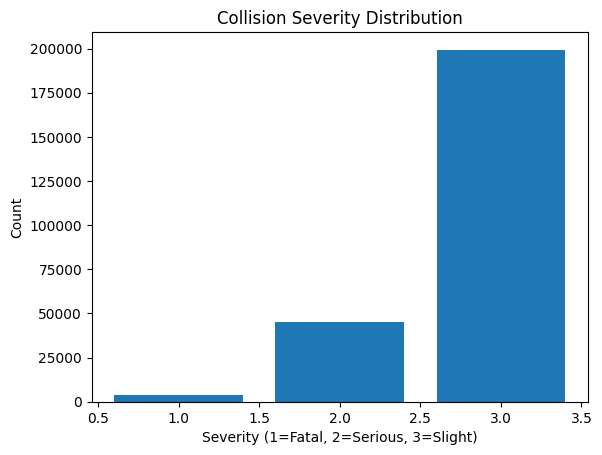

In [80]:
import matplotlib.pyplot as plt

severity_pd = df.groupBy("collision_severity") \
                .count() \
                .orderBy("collision_severity") \
                .toPandas()

plt.figure()
plt.bar(severity_pd["collision_severity"], severity_pd["count"])
plt.title("Collision Severity Distribution")
plt.xlabel("Severity (1=Fatal, 2=Serious, 3=Slight)")
plt.ylabel("Count")
plt.show()

In [81]:
year_trend = df.groupBy("collision_year") \
               .count() \
               .orderBy("collision_year")

year_trend.show()

+--------------+-----+
|collision_year|count|
+--------------+-----+
|          1979| 6544|
|          1980| 6132|
|          1981| 6147|
|          1982| 6435|
|          1983| 6108|
|          1984| 6302|
|          1985| 6212|
|          1986| 6245|
|          1987| 6057|
|          1988| 6082|
|          1989| 6355|
|          1990| 6565|
|          1991| 5799|
|          1992| 5772|
|          1993| 5779|
|          1994| 6790|
|          1995| 6494|
|          1996| 7136|
|          1997| 7030|
|          1998| 7059|
+--------------+-----+
only showing top 20 rows


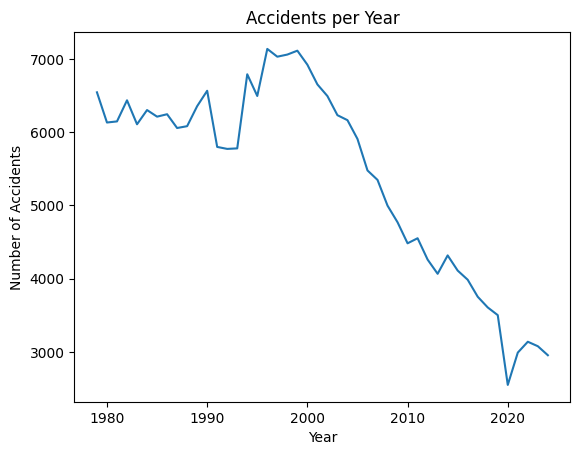

In [82]:
year_pd = year_trend.toPandas()

plt.figure()
plt.plot(year_pd["collision_year"], year_pd["count"])
plt.title("Accidents per Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.show()

In [84]:
df.groupBy("speed_limit") \
  .count() \
  .orderBy("speed_limit") \
  .show()

+-----------+------+
|speed_limit| count|
+-----------+------+
|         -1|     4|
|          0|    15|
|          5|     3|
|         10|    18|
|         15|    11|
|         20|  4266|
|         21|     2|
|         25|     1|
|         30|161010|
|         31|     2|
|         37|     1|
|         40| 19556|
|         41|     1|
|         42|     2|
|         50|  5139|
|         51|     1|
|         60| 42132|
|         61|     2|
|         63|     1|
|         66|     1|
+-----------+------+
only showing top 20 rows


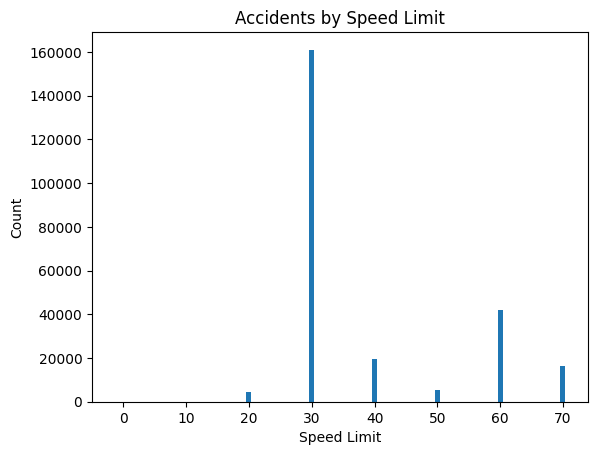

In [85]:
speed_pd = df.groupBy("speed_limit") \
             .count() \
             .orderBy("speed_limit") \
             .toPandas()

plt.figure()
plt.bar(speed_pd["speed_limit"], speed_pd["count"])
plt.title("Accidents by Speed Limit")
plt.xlabel("Speed Limit")
plt.ylabel("Count")
plt.show()

In [86]:
df.groupBy("weather_conditions") \
  .count() \
  .orderBy("weather_conditions") \
  .show()

+------------------+------+
|weather_conditions| count|
+------------------+------+
|                -1|    48|
|                 1|192096|
|                 2| 33372|
|                 3|  1471|
|                 4|  3649|
|                 5|  3524|
|                 6|   406|
|                 7|  1768|
|                 8|  8635|
|                 9|  3528|
+------------------+------+



In [87]:
df.groupBy("weather_conditions") \
  .count() \
  .orderBy("weather_conditions") \
  .show()

+------------------+------+
|weather_conditions| count|
+------------------+------+
|                -1|    48|
|                 1|192096|
|                 2| 33372|
|                 3|  1471|
|                 4|  3649|
|                 5|  3524|
|                 6|   406|
|                 7|  1768|
|                 8|  8635|
|                 9|  3528|
+------------------+------+



In [88]:
numeric_cols = [
    "collision_year",
    "number_of_vehicles",
    "number_of_casualties",
    "speed_limit"
]

for col_name in numeric_cols:
    print(f"Correlation with severity ({col_name}):",
          df.stat.corr(col_name, "collision_severity"))

Correlation with severity (collision_year): 0.07157777464025301
Correlation with severity (number_of_vehicles): 0.07446692534388602
Correlation with severity (number_of_casualties): -0.13184613662613784
Correlation with severity (speed_limit): -0.09730383806518868
